# CA Coronavirus Cases and Deaths Trends

CA's [Blueprint for a Safer Economy](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyMonitoringOverview.aspx) assigns each county [to a tier](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyMonitoringOverview.aspx) based on case rate and test positivity rate. What's opened / closed [under each tier](https://www.cdph.ca.gov/Programs/CID/DCDC/CDPH%20Document%20Library/COVID-19/Dimmer-Framework-September_2020.pdf).

Tiers, from most severe to least severe, categorizes coronavirus spread as <strong><span style='color:#6B1F84'>widespread; </span></strong>
<strong><span style='color:#F3324C'>substantial; </span></strong><strong><span style='color:#F7AE1D'>moderate; </span></strong><strong><span style = 'color:#D0E700'>or minimal.</span></strong>
**Counties must stay in the current tier for 3 consecutive weeks and metrics from the last 2 consecutive weeks must fall into less restrictive tier before moving into a less restrictive tier.**

We show *only* case charts labeled with each county's population-adjusted tier cut-offs.

**Related daily reports:** 
1. **[US counties report on cases and deaths for select major cities](https://cityoflosangeles.github.io/covid19-indicators/us-county-trends.html)**
1. **[Los Angeles County, detailed indicators](https://cityoflosangeles.github.io/covid19-indicators/coronavirus-stats.html)**
1. **[Los Angeles County neighborhoods report on cases and deaths](https://cityoflosangeles.github.io/covid19-indicators/la-neighborhoods-trends.html)**

Code available in GitHub: [https://github.com/CityOfLosAngeles/covid19-indicators](https://github.com/CityOfLosAngeles/covid19-indicators)
<br>
Get informed with [public health research](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/reopening-sources.md)

In [1]:
import altair as alt
import altair_saver
import geopandas as gpd
import os
import pandas as pd

from processing_utils import default_parameters
from processing_utils import make_charts
from processing_utils import make_maps
from processing_utils import neighborhood_utils
from processing_utils import us_county_utils
from processing_utils import utils

from datetime import date, datetime, timedelta
from IPython.display import display_html, Markdown, HTML, Image

# For map
import branca.colormap
import ipywidgets
# There's a warning that comes up about projects, suppress
import warnings
warnings.filterwarnings("ignore")

# Default parameters
S3_FILE_PATH = default_parameters.S3_FILE_PATH
S3_FILE_PATH_SOURCE = default_parameters.S3_FILE_PATH_SOURCE
time_zone = default_parameters.time_zone
start_date = datetime(2021, 3, 1).date()
today_date = default_parameters.today_date

fulldate_format = default_parameters.fulldate_format

#alt.renderers.enable('html')

In [2]:
STATE = "CA"

jhu = us_county_utils.clean_jhu(start_date)
jhu = jhu[jhu.state_abbrev==STATE]

hospitalizations = us_county_utils.clean_hospitalizations(start_date)

vaccinations = utils.clean_vaccines_by_county()
vaccinations_demog = utils.clean_vaccines_by_demographics()

ca_counties = list(jhu[jhu.state_abbrev==STATE].county.unique()) 

# Put LA county first
ca_counties.remove("Los Angeles")
ca_counties = ["Los Angeles"] + ca_counties

data_through = jhu.date.max()

In [3]:
display(Markdown(
        f"Report updated: {default_parameters.today_date.strftime(fulldate_format)}; "
        f"data available through {data_through.strftime(fulldate_format)}."
    )
)

Report updated: 5/27/22; data available through 5/26/22.

In [4]:
title_font_size = 9

def plot_charts(cases_df, hospital_df, vaccine_df, vaccine_demog_df, county_name):
    cases_df = cases_df[cases_df.county==county_name]
    hospital_df = hospital_df[hospital_df.county==county_name]
    vaccine_df = vaccine_df[vaccine_df.county==county_name]
    vaccine_df2 = vaccine_demog_df[vaccine_demog_df.county==county_name]
    
    name = cases_df.county.iloc[0]
    
    cases_chart, deaths_chart = make_charts.setup_cases_deaths_chart(cases_df, "county", name)
    hospitalizations_chart = make_charts.setup_county_covid_hospital_chart(
        hospital_df.drop(columns = "date"), county_name)
    
    vaccines_type_chart = make_charts.setup_county_vaccination_doses_chart(vaccine_df, county_name)
    vaccines_pop_chart = make_charts.setup_county_vaccinated_population_chart(vaccine_df, county_name)
    vaccines_age_chart = make_charts.setup_county_vaccinated_category(vaccine_df2, county_name, category="Age Group")
    
    outbreak_chart = (alt.hconcat(
                        cases_chart, 
                        deaths_chart, 
                        make_charts.add_tooltip(hospitalizations_chart, "hospitalizations")
                    ).configure_concat(spacing=50)
                     )
    
    #https://stackoverflow.com/questions/60328943/how-to-display-two-different-legends-in-hconcat-chart-using-altair
    vaccines_chart = (alt.hconcat(
                        make_charts.add_tooltip(vaccines_type_chart, "vaccines_type"), 
                        make_charts.add_tooltip(vaccines_pop_chart, "vaccines_pop"), 
                        make_charts.add_tooltip(vaccines_age_chart, "vaccines_age"),
                    ).resolve_scale(color="independent")
                      .configure_view(stroke=None)
                      .configure_concat(spacing=0)
                     )
        
    outbreak_chart = (make_charts.configure_chart(outbreak_chart)
              .configure_title(fontSize=title_font_size)
            )
    
    vaccines_chart = (make_charts.configure_chart(vaccines_chart)
                      .configure_title(fontSize=title_font_size)
                     )
    
    county_state_name = county_name + f", {STATE}"
    display(Markdown(f"#### {county_state_name}"))
    try:
        us_county_utils.county_caption(cases_df, county_name)
    except:
        pass
    us_county_utils.ca_hospitalizations_caption(hospital_df, county_name)
    us_county_utils.ca_vaccinations_caption(vaccine_df, county_name)
    
    make_charts.show_svg(outbreak_chart)
    make_charts.show_svg(vaccines_chart)


<strong>Cases chart, explained</strong>

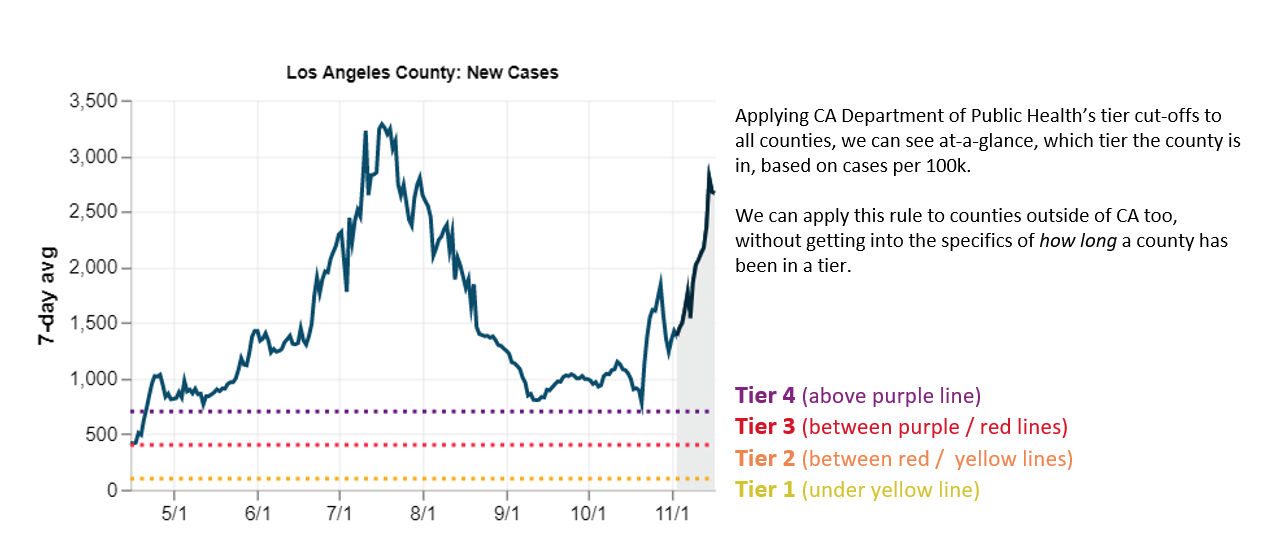

In [5]:
display(Markdown("<strong>Cases chart, explained</strong>"))
Image("../notebooks/chart_parts_explained.png", width=700)

<a id='counties_by_region'></a>

## Counties by Region
<strong>Superior California Region: </strong> [Butte](#Butte), Colusa, 
[El Dorado](#El-Dorado), 
Glenn, 
[Lassen](#Lassen), Modoc, 
[Nevada](#Nevada), 
[Placer](#Placer), Plumas, 
[Sacramento](#Sacramento), 
[Shasta](#Shasta), Sierra, Siskiyou, 
[Sutter](#Sutter), 
[Tehama](#Tehama), 
[Yolo](#Yolo), 
[Yuba](#Yuba)
<br>
<strong>North Coast:</strong> [Del Norte](#Del-Norte), 
[Humboldt](#Humboldt), 
[Lake](#Lake), 
[Mendocino](#Mendocino), 
[Napa](#Napa), 
[Sonoma](#Sonoma), Trinity
<br>
<strong>San Francisco Bay Area:</strong> [Alameda](#Alameda), 
[Contra Costa](#Contra-Costa), 
[Marin](#Marin), 
[San Francisco](#San-Francisco), 
[San Mateo](#San-Mateo), 
[Santa Clara](#Santa-Clara), 
[Solano](#Solano)
<br>
<strong>Northern San Joaquin Valley:</strong> Alpine, Amador, Calaveras, 
[Madera](#Madera), Mariposa, 
[Merced](#Merced), 
Mono, 
[San Joaquin](#San-Joaquin), 
[Stanislaus](#Stanislaus), 
[Tuolumne](#Tuolumne)
<br>
<strong>Central Coast:</strong> [Monterey](#Monterey), 
[San Benito](#San-Benito), 
[San Luis Obispo](#San-Luis-Obispo), 
[Santa Barbara](#Santa-Barbara), 
[Santa Cruz](#Santa-Cruz), 
[Ventura](#Ventura)
<br>
<strong>Southern San Joaquin Valley:</strong> [Fresno](#Fresno), 
Inyo, 
[Kern](#Kern), 
[Kings](#Kings), 
[Tulare](#Tulare)
<br>
<strong>Southern California:</strong> [Los Angeles](#Los-Angeles), 
[Orange](#Orange), 
[Riverside](#Riverside), 
[San Bernardino](#San-Bernardino)
<br>
<strong>San Diego-Imperial:</strong> [Imperial](#Imperial), 
[San Diego](#San-Diego)
<br>
<br>
[**Summary of CA County Severity Map**](#summary)
<br>
[**Vaccinations by Zip Code**](#vax_map)

Note for <i>small values</i>: If the 7-day rolling average of new cases or new deaths is under 10, the 7-day rolling average is listed for the past week, rather than a percent change. Given that it is a rolling average, decimals are possible, and are rounded to 1 decimal place. Similarly for hospitalizations.

#### Los Angeles, CA

As of 5/26/22, there were **2,955,954** total cases and **32,109** total deaths. <br>In the past week, new cases grew by **26.2%**; new deaths went from **6.9** to **6.4**. <br>New cases are **5.9x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **634 days** to **471 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations grew by **17.7%**.; COVID ICU hospitalizations grew by **15.3%**. 

**19,585,296** cumulative doses have been administered (83,626 doses administered in the past week). Already, **79.5%** of the county has received at least 1 dose and **72.0%** is fully vaccinated.

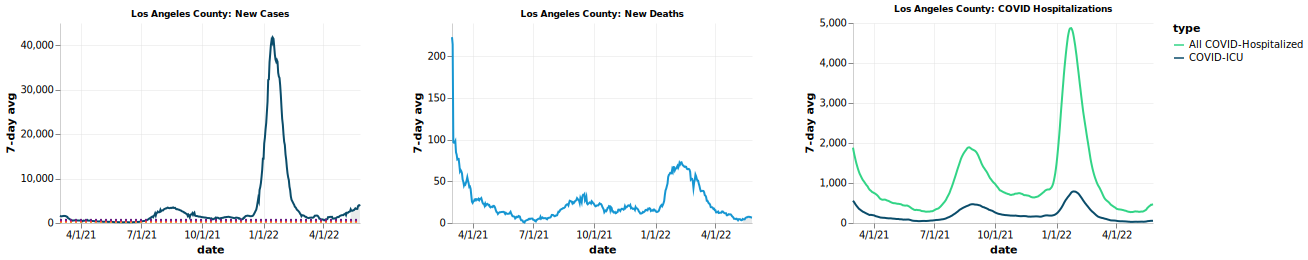

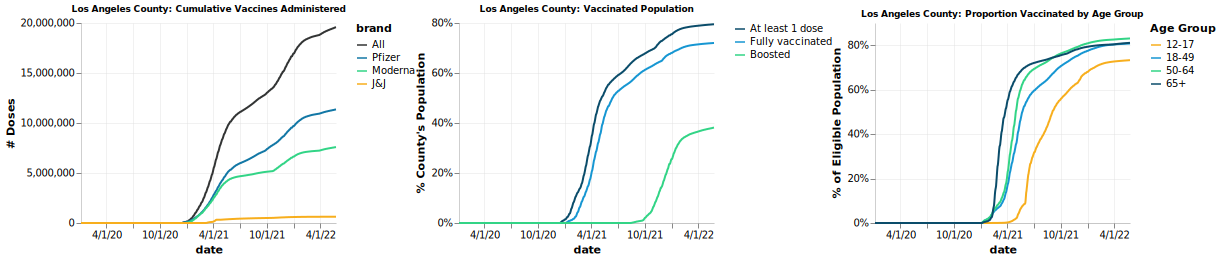

#### Alameda, CA

As of 5/26/22, there were **293,830** total cases and **1,860** total deaths. <br>In the past week, new cases grew by **-49.0%**; new deaths went from **0.9** to **0.1**. <br>New cases are **3.9x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **190 days** to **376 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations grew by **21.7%**.; COVID ICU hospitalizations went from **8.1** to **8.3**. 

**3,765,363** cumulative doses have been administered (20,924 doses administered in the past week). Already, **89.0%** of the county has received at least 1 dose and **81.3%** is fully vaccinated.

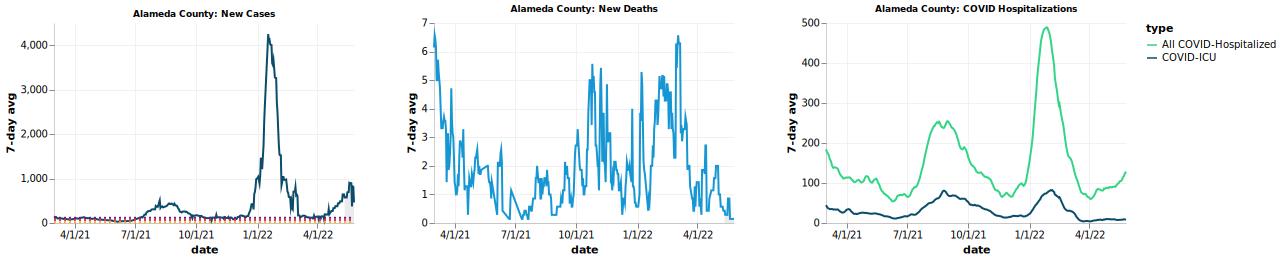

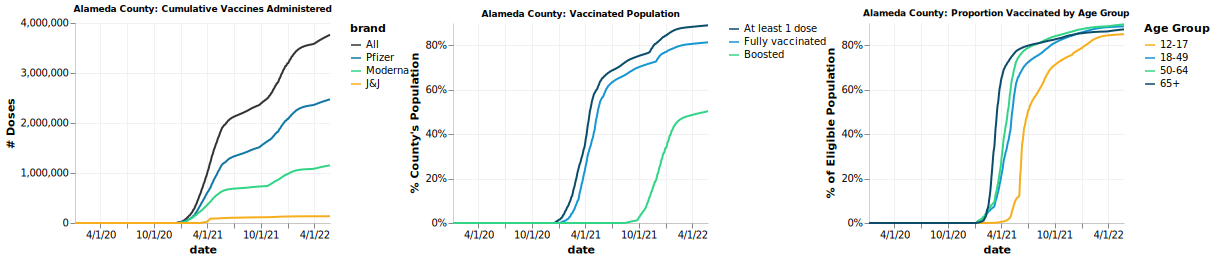

#### Butte, CA

As of 5/26/22, there were **40,651** total cases and **426** total deaths. <br>In the past week, new cases grew by **-48.6%**; new deaths went from **0.4** to **0.0**. <br>New cases are **1.4x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **595 days** to **1,118 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **5.9** to **7.6**.; COVID ICU hospitalizations went from **0.1** to **0.4**. 

**307,843** cumulative doses have been administered (1,258 doses administered in the past week). Already, **58.5%** of the county has received at least 1 dose and **53.8%** is fully vaccinated.

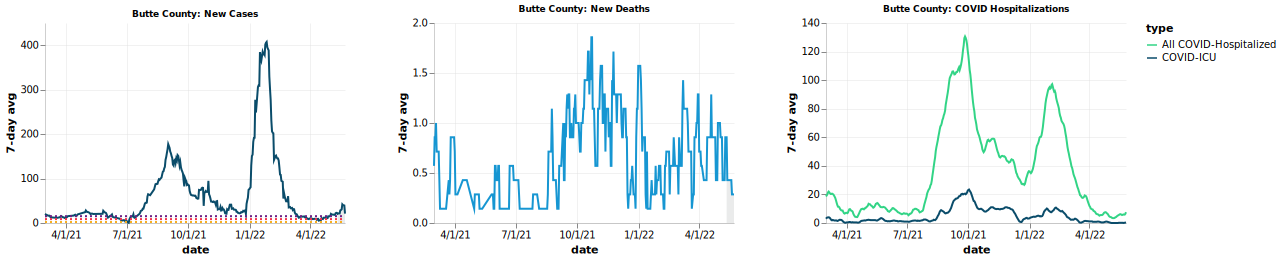

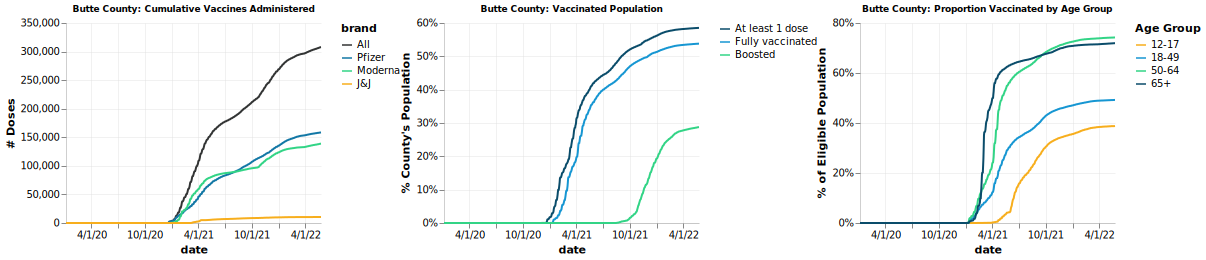

#### Contra Costa, CA

As of 5/26/22, there were **216,355** total cases and **1,306** total deaths. <br>In the past week, new cases grew by **-46.0%**; new deaths went from **0.1** to **0.4**. <br>New cases are **3.8x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **223 days** to **414 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations grew by **19.0%**.; COVID ICU hospitalizations grew by **1.1%**. 

**2,611,243** cumulative doses have been administered (13,814 doses administered in the past week). Already, **87.6%** of the county has received at least 1 dose and **82.2%** is fully vaccinated.

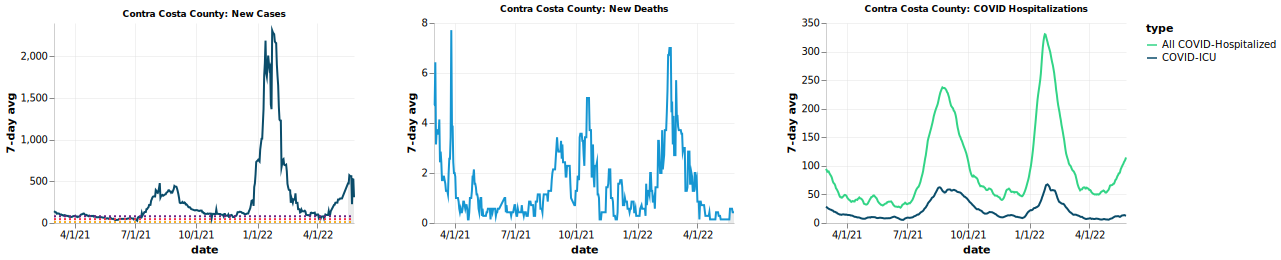

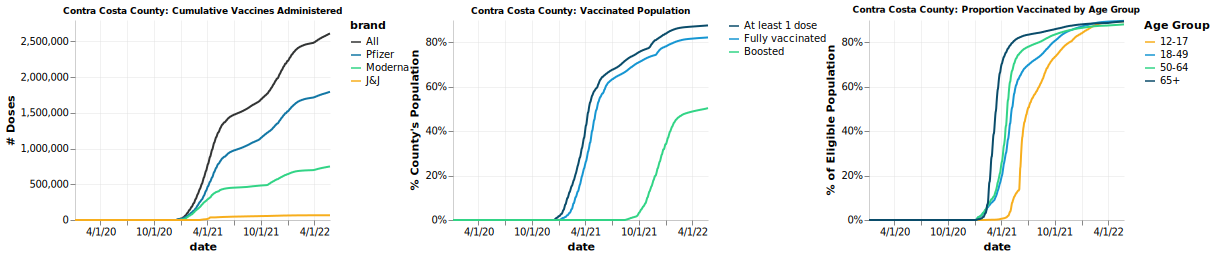

#### Del Norte, CA

As of 5/26/22, there were **6,366** total cases and **50** total deaths. <br>In the past week, new cases grew by **-24.2%**; new deaths went from **0.0** to **0.0**. <br>New cases are **7.3x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **198 days** to **263 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **0.0** to **1.0**.; COVID ICU hospitalizations went from **0.0** to **0.3**. 

**35,042** cumulative doses have been administered (176 doses administered in the past week). Already, **54.7%** of the county has received at least 1 dose and **48.6%** is fully vaccinated.

WARN Infinite extent for field "date2": [Infinity, -Infinity]


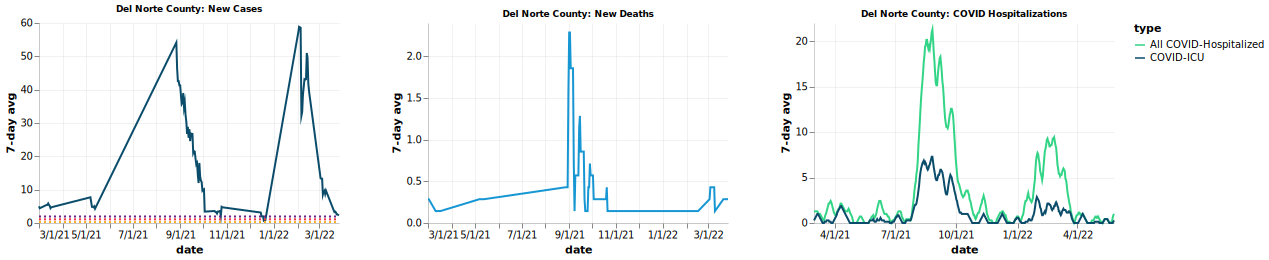

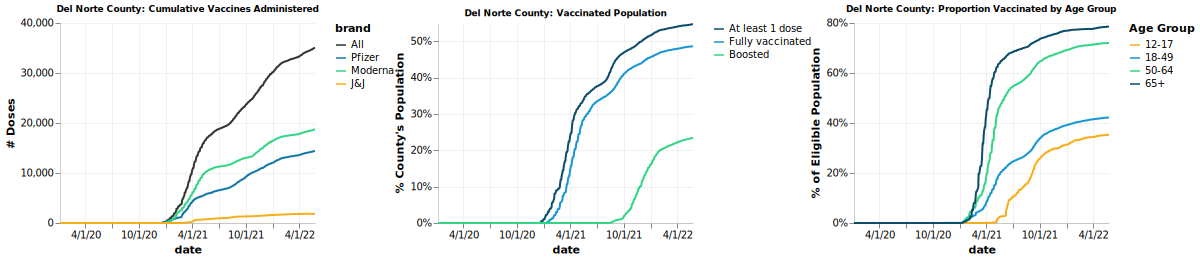

#### El Dorado, CA

As of 5/26/22, there were **31,054** total cases and **213** total deaths. <br>In the past week, new cases grew by **-40.2%**; new deaths went from **0.0** to **0.1**. <br>New cases are **2.1x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **395 days** to **650 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **5.7** to **5.4**.; COVID ICU hospitalizations went from **0.7** to **0.7**. 

**318,217** cumulative doses have been administered (1,662 doses administered in the past week). Already, **67.3%** of the county has received at least 1 dose and **61.1%** is fully vaccinated.

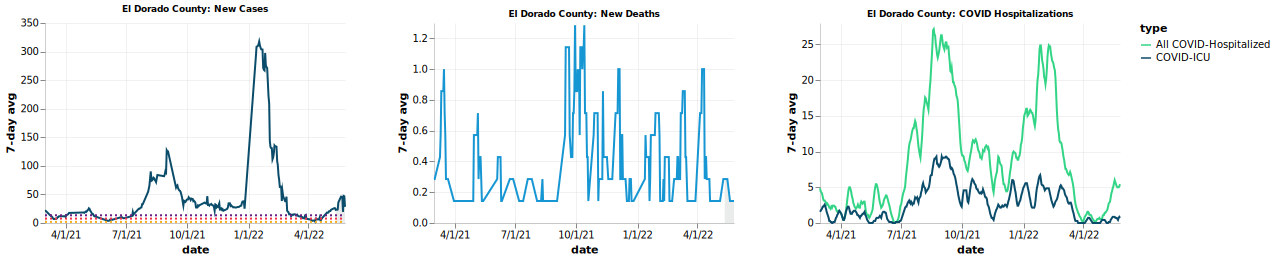

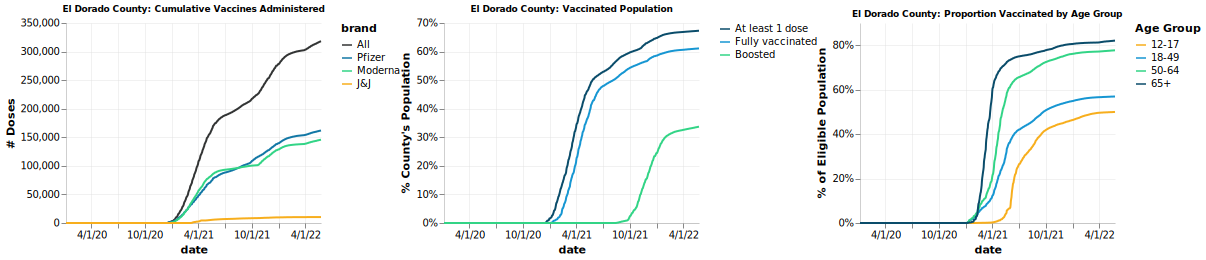

#### Fresno, CA

As of 5/26/22, there were **260,088** total cases and **2,763** total deaths. <br>In the past week, new cases grew by **-36.2%**; new deaths went from **0.7** to **0.6**. <br>New cases are **1.9x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **754 days** to **1,178 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations grew by **26.0%**.; COVID ICU hospitalizations went from **7.0** to **8.6**. 

**1,582,998** cumulative doses have been administered (5,225 doses administered in the past week). Already, **66.7%** of the county has received at least 1 dose and **59.5%** is fully vaccinated.

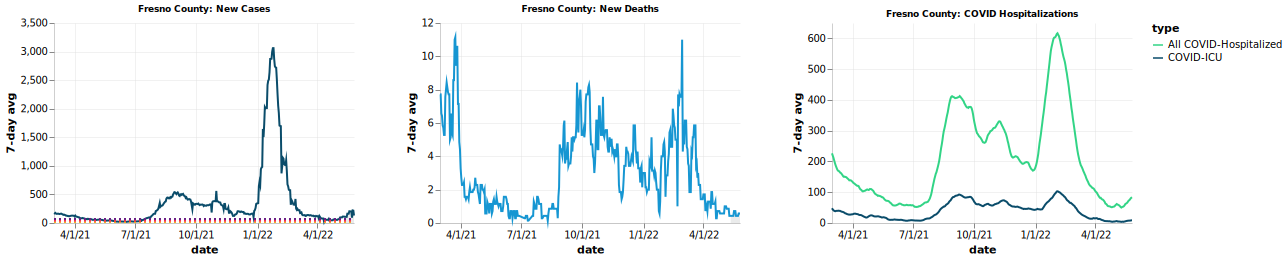

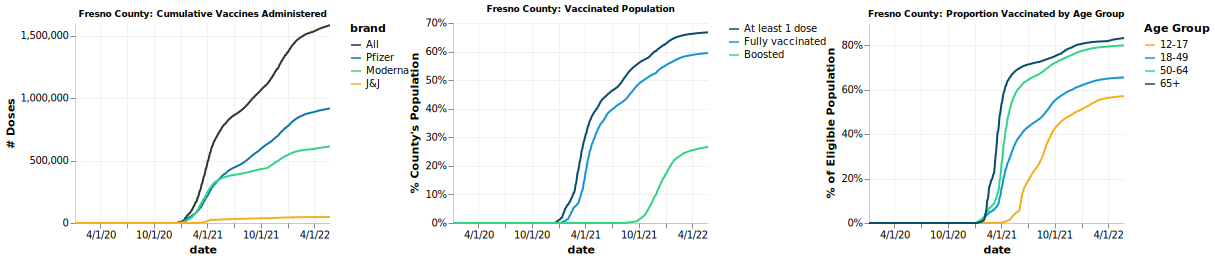

#### Humboldt, CA

As of 5/26/22, there were **21,766** total cases and **147** total deaths. <br>In the past week, new cases grew by **5.3%**; new deaths went from **0.0** to **0.1**. <br>New cases are **6.9x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **207 days** to **195 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations grew by **16.8%**.; COVID ICU hospitalizations went from **2.6** to **3.7**. 

**242,646** cumulative doses have been administered (1,381 doses administered in the past week). Already, **73.3%** of the county has received at least 1 dose and **67.3%** is fully vaccinated.

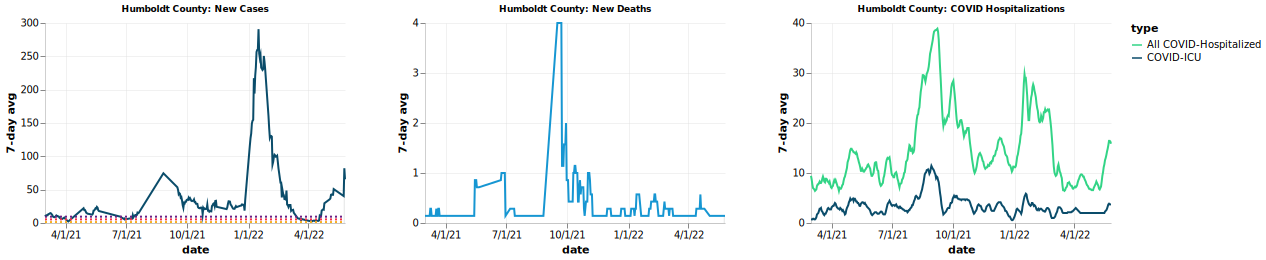

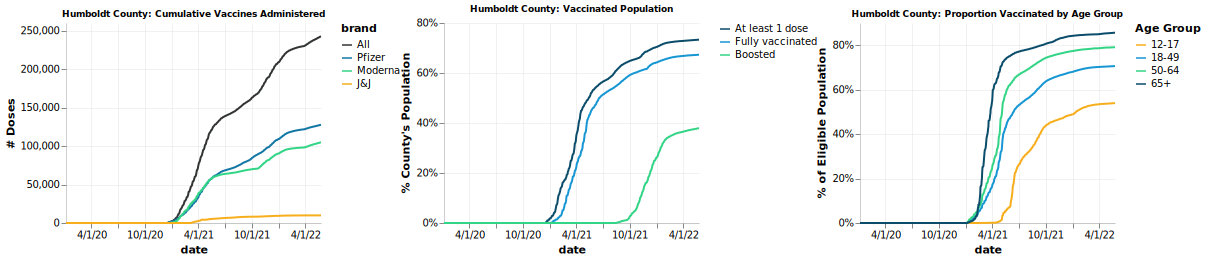

#### Imperial, CA

As of 5/26/22, there were **67,281** total cases and **934** total deaths. <br>In the past week, new cases grew by **-41.3%**; new deaths went from **0.1** to **2.3**. <br>New cases are **2.1x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **889 days** to **1,478 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **4.1** to **4.6**.; COVID ICU hospitalizations went from **1.6** to **1.4**. 

**470,417** cumulative doses have been administered (1,783 doses administered in the past week). Already, **126.1%** of the county has received at least 1 dose and **90.5%** is fully vaccinated.

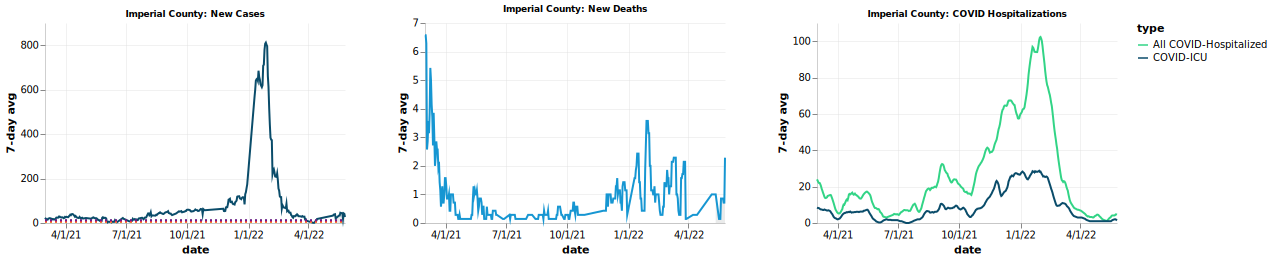

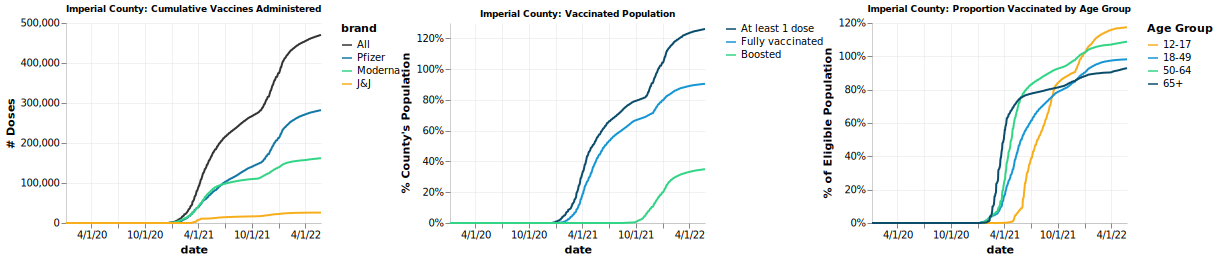

#### Kern, CA

As of 5/26/22, there were **246,310** total cases and **2,444** total deaths. <br>In the past week, new cases grew by **45.9%**; new deaths went from **4.4** to **2.4**. <br>New cases are **2.8x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **2,680 days** to **1,189 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations grew by **54.8%**.; COVID ICU hospitalizations went from **3.3** to **6.0**. 

**1,217,490** cumulative doses have been administered (4,135 doses administered in the past week). Already, **58.1%** of the county has received at least 1 dose and **52.3%** is fully vaccinated.

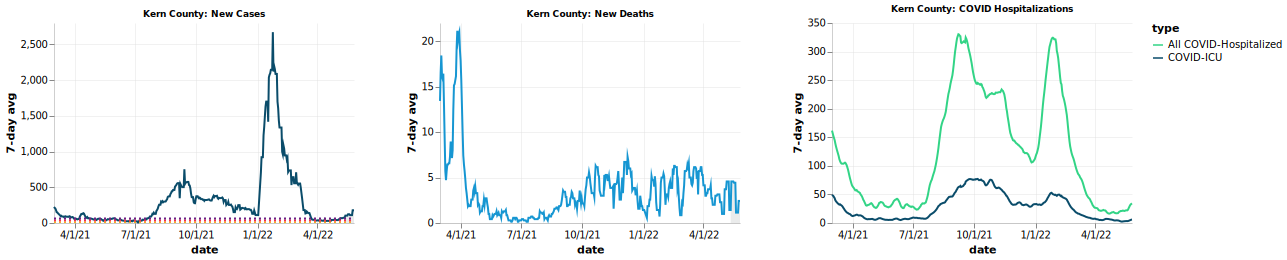

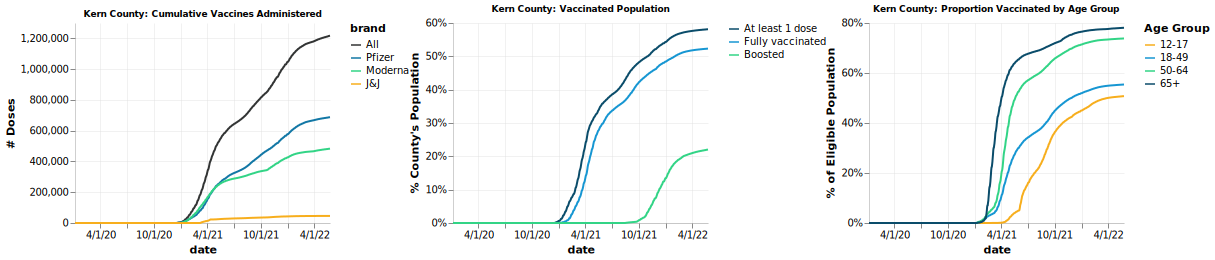

#### Kings, CA

As of 5/26/22, there were **55,843** total cases and **447** total deaths. <br>In the past week, new cases grew by **-46.1%**; new deaths went from **0.0** to **0.0**. <br>New cases are **1.9x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **859 days** to **1,589 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **0.0** to **1.3**.; COVID ICU hospitalizations went from **0.0** to **0.1**. 

**173,925** cumulative doses have been administered (540 doses administered in the past week). Already, **50.1%** of the county has received at least 1 dose and **44.3%** is fully vaccinated.

WARN Infinite extent for field "date2": [Infinity, -Infinity]


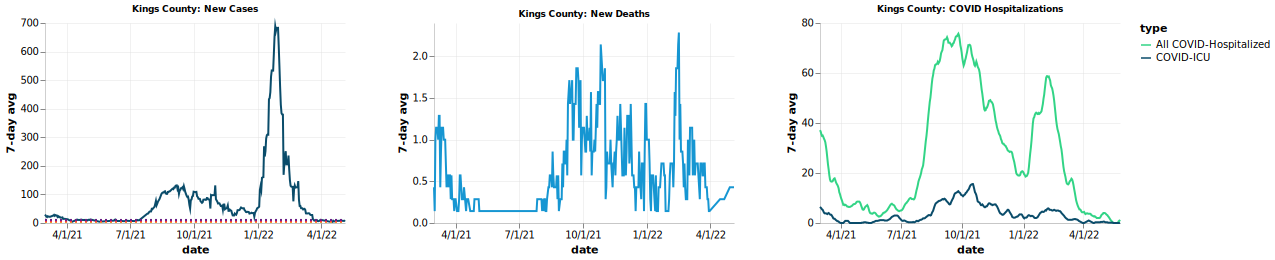

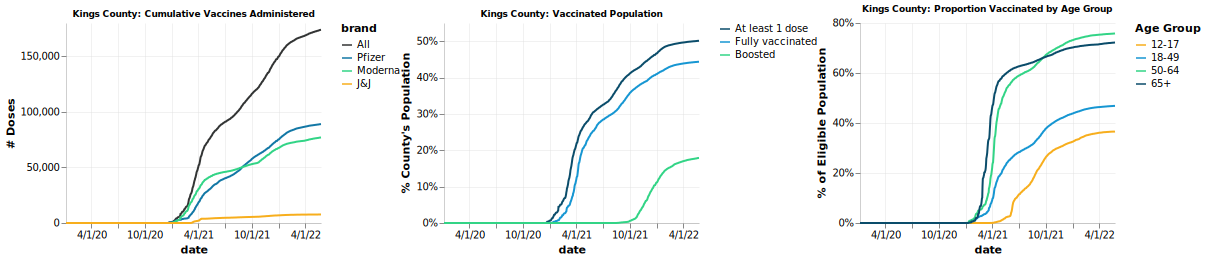

#### Lake, CA

As of 5/26/22, there were **11,833** total cases and **137** total deaths. <br>In the past week, new cases went from **12.9**  to **6**; new deaths went from **0.0** to **0.0**. <br>New cases are **1.3x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **562 days** to **1,198 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **1.0** to **1.6**.; COVID ICU hospitalizations went from **0.0** to **0.9**. 

**92,998** cumulative doses have been administered (353 doses administered in the past week). Already, **61.4%** of the county has received at least 1 dose and **54.8%** is fully vaccinated.

WARN Infinite extent for field "date2": [Infinity, -Infinity]


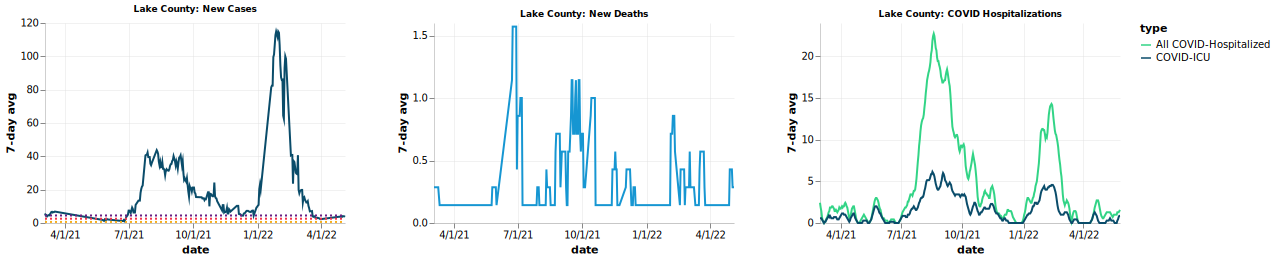

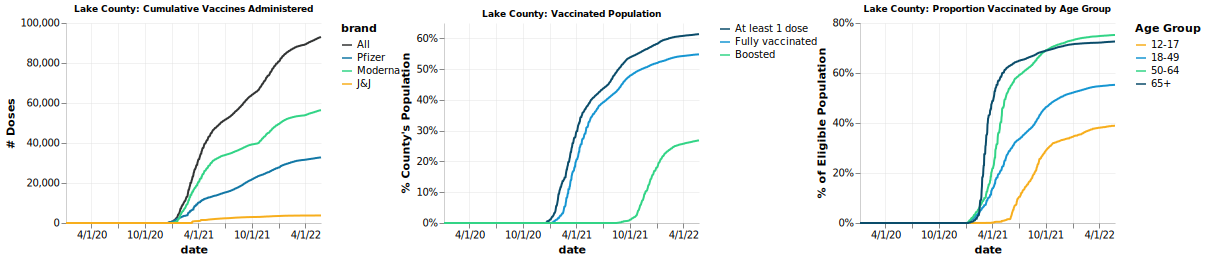

#### Lassen, CA

As of 5/26/22, there were **9,927** total cases and **64** total deaths. <br>In the past week, new cases went from **1.7**  to **6**; new deaths went from **0.0** to **-0.1**. <br>New cases are **2.7x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **5,871 days** to **2,426 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **0.6** to **0.3**.; COVID ICU hospitalizations went from **0.0** to **0.0**. 

**21,879** cumulative doses have been administered (85 doses administered in the past week). Already, **32.8%** of the county has received at least 1 dose and **29.6%** is fully vaccinated.

WARN Infinite extent for field "date2": [Infinity, -Infinity]


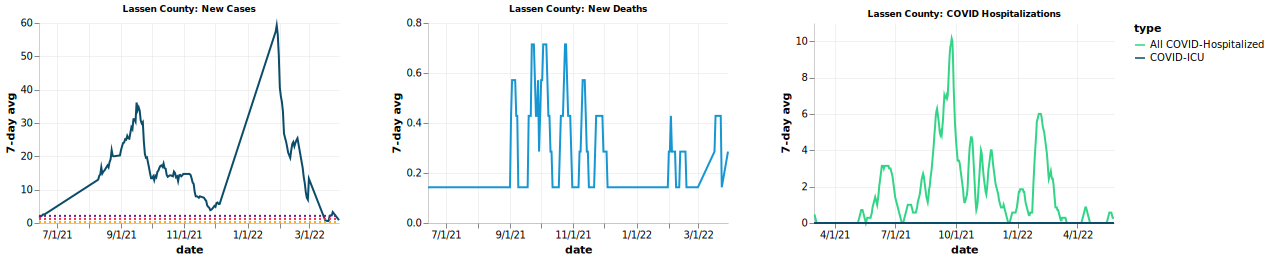

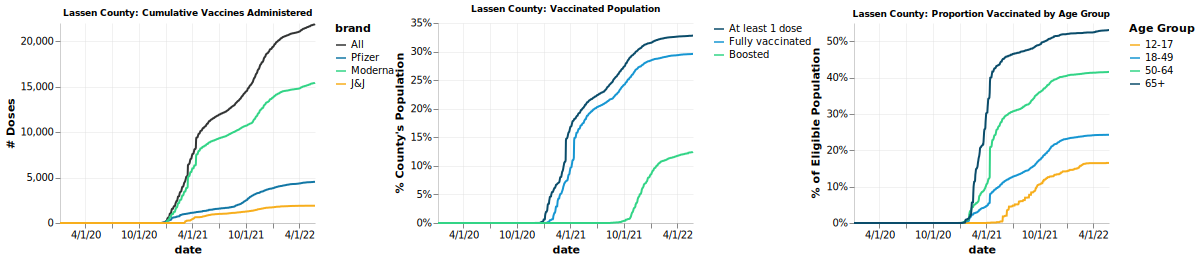

#### Madera, CA

As of 5/26/22, there were **44,146** total cases and **381** total deaths. <br>In the past week, new cases grew by **-53.7%**; new deaths went from **1.6** to **0.1**. <br>New cases are **1.6x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **697 days** to **1,467 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **6.4** to **6.6**.; COVID ICU hospitalizations went from **0.7** to **2.3**. 

**220,919** cumulative doses have been administered (791 doses administered in the past week). Already, **61.7%** of the county has received at least 1 dose and **53.7%** is fully vaccinated.

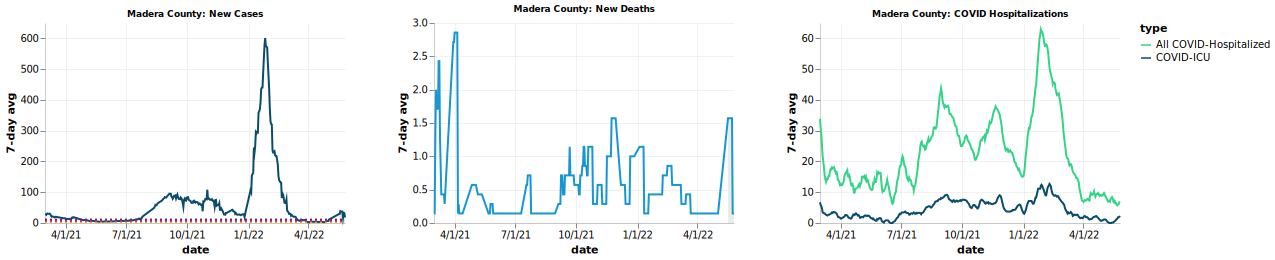

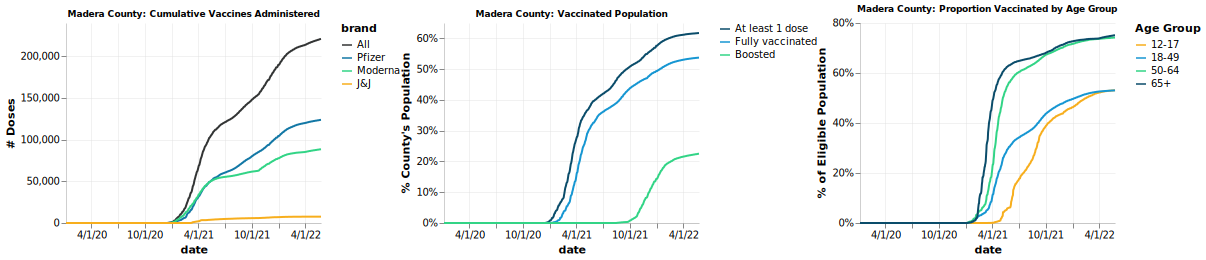

#### Marin, CA

As of 5/26/22, there were **40,412** total cases and **293** total deaths. <br>In the past week, new cases grew by **-56.3%**; new deaths went from **0.1** to **0.0**. <br>New cases are **3.9x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **147 days** to **337 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations grew by **3.3%**.; COVID ICU hospitalizations went from **1.9** to **1.1**. 

**655,453** cumulative doses have been administered (5,028 doses administered in the past week). Already, **93.4%** of the county has received at least 1 dose and **87.1%** is fully vaccinated.

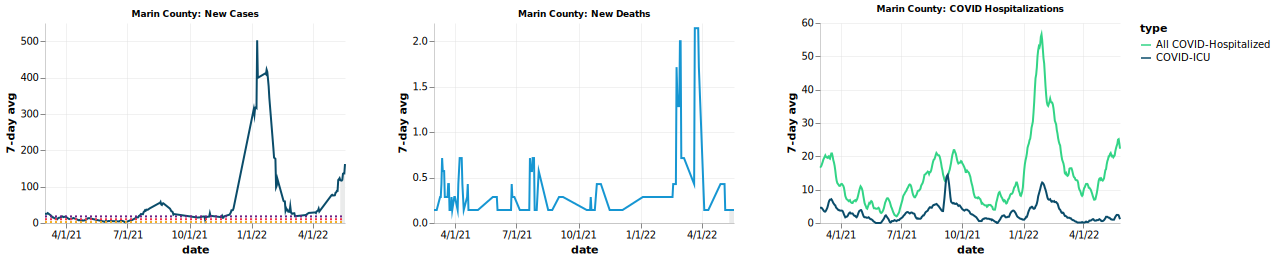

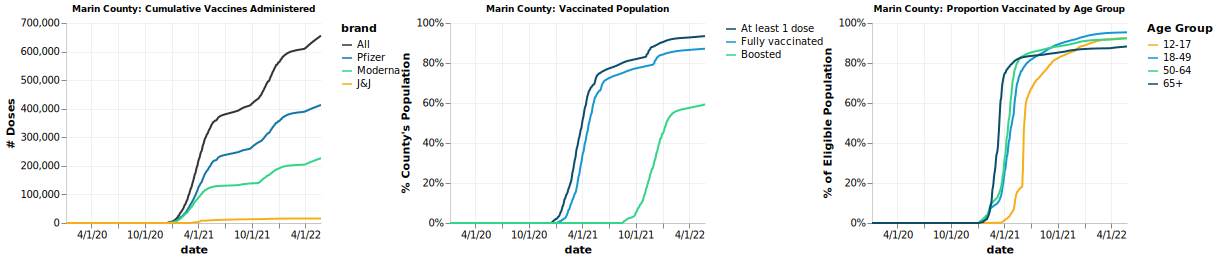

#### Mendocino, CA

As of 5/26/22, there were **16,898** total cases and **127** total deaths. <br>In the past week, new cases grew by **-48.8%**; new deaths went from **0.0** to **0.0**. <br>New cases are **2.1x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **432 days** to **797 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **2.9** to **3.7**.; COVID ICU hospitalizations went from **1.3** to **0.9**. 

**163,237** cumulative doses have been administered (828 doses administered in the past week). Already, **75.5%** of the county has received at least 1 dose and **67.7%** is fully vaccinated.

WARN Infinite extent for field "date2": [Infinity, -Infinity]


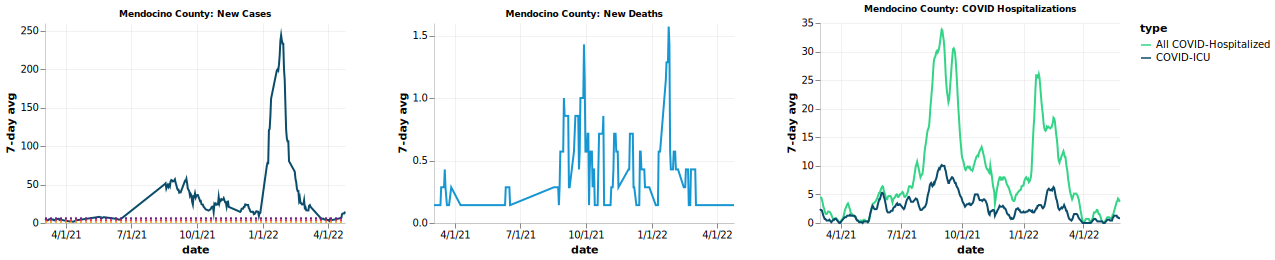

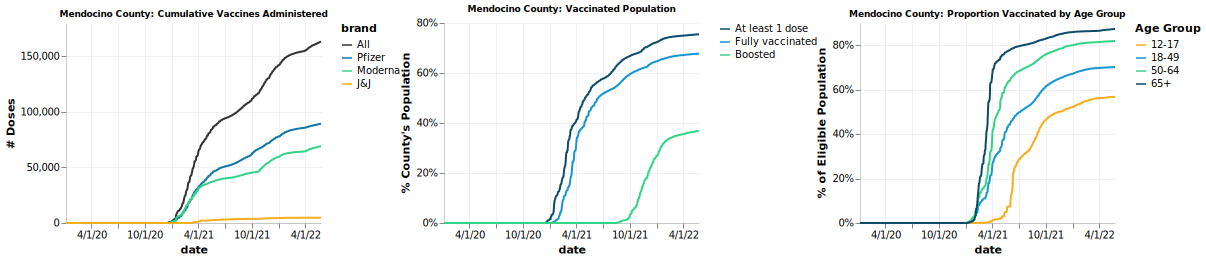

#### Merced, CA

As of 5/26/22, there were **72,268** total cases and **823** total deaths. <br>In the past week, new cases grew by **-43.5%**; new deaths went from **0.0** to **0.7**. <br>New cases are **1.8x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **694 days** to **1,195 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **7.0** to **4.1**.; COVID ICU hospitalizations went from **0.7** to **0.0**. 

**383,677** cumulative doses have been administered (1,205 doses administered in the past week). Already, **68.2%** of the county has received at least 1 dose and **50.0%** is fully vaccinated.

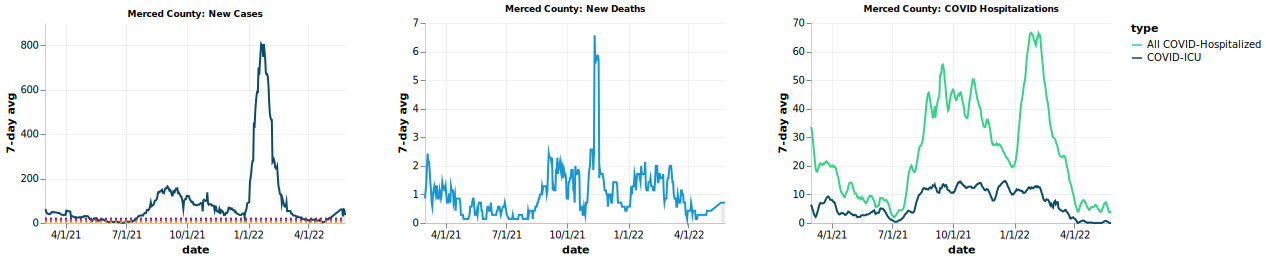

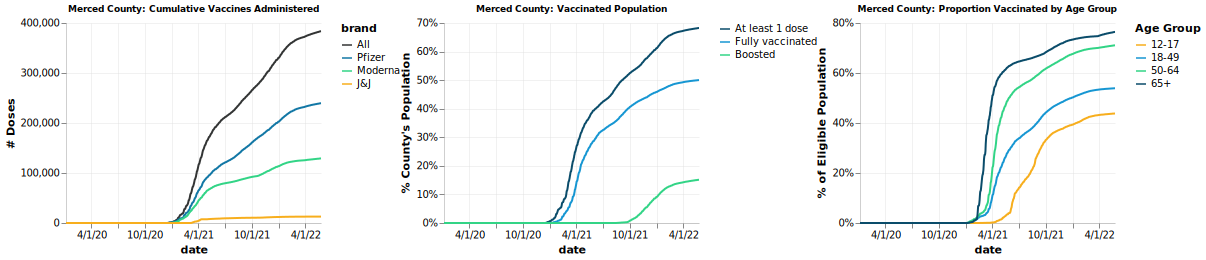

#### Monterey, CA

As of 5/26/22, there were **96,561** total cases and **737** total deaths. <br>In the past week, new cases grew by **-55.0%**; new deaths went from **0.3** to **0.3**. <br>New cases are **1.7x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **504 days** to **1,083 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **9.1** to **13.9**.; COVID ICU hospitalizations went from **0.6** to **1.4**. 

**828,823** cumulative doses have been administered (3,641 doses administered in the past week). Already, **78.5%** of the county has received at least 1 dose and **70.9%** is fully vaccinated.

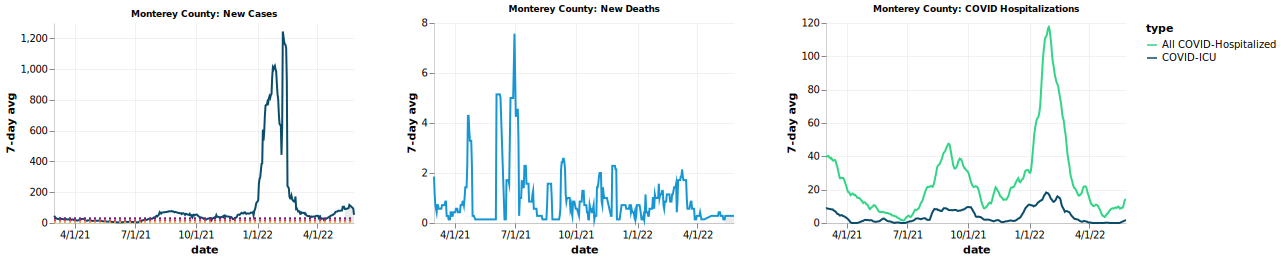

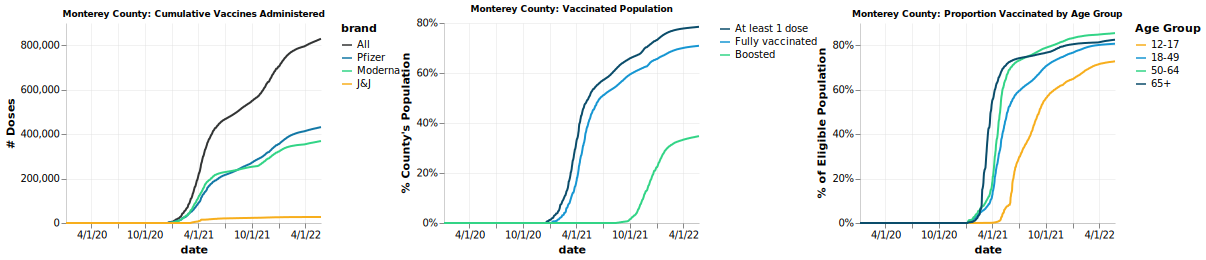

#### Napa, CA

As of 5/26/22, there were **28,336** total cases and **143** total deaths. <br>In the past week, new cases grew by **-41.5%**; new deaths went from **0.0** to **0.0**. <br>New cases are **3.1x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **331 days** to **570 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **2.4** to **5.0**.; COVID ICU hospitalizations went from **0.4** to **0.7**. 

**304,669** cumulative doses have been administered (1,350 doses administered in the past week). Already, **86.5%** of the county has received at least 1 dose and **78.3%** is fully vaccinated.

WARN Infinite extent for field "date2": [Infinity, -Infinity]


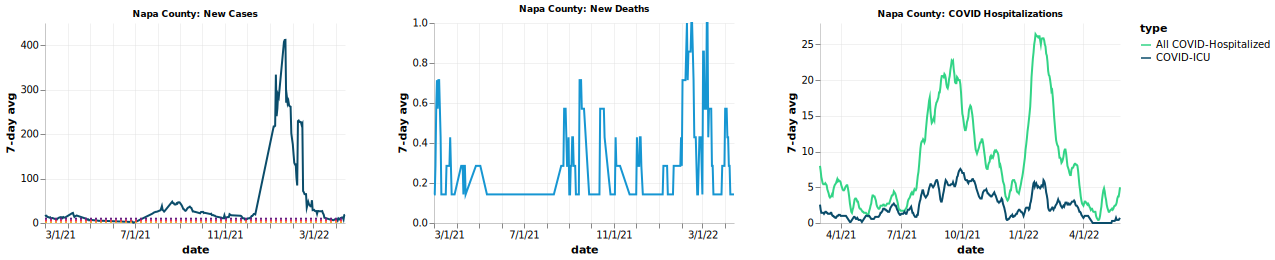

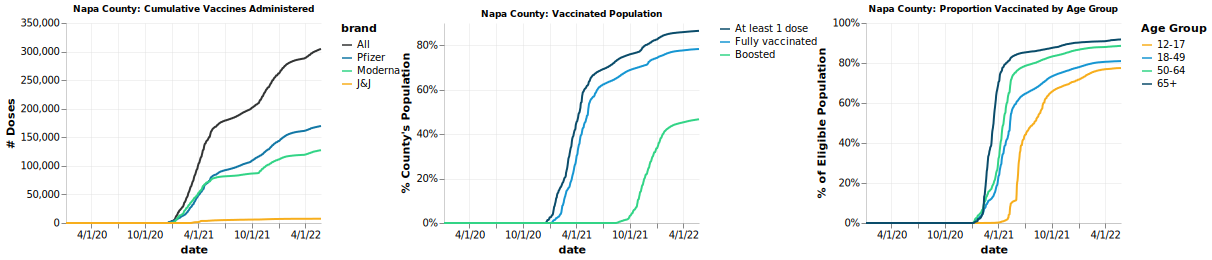

#### Nevada, CA

As of 5/26/22, there were **17,799** total cases and **127** total deaths. <br>In the past week, new cases grew by **-39.9%**; new deaths went from **0.0** to **0.0**. <br>New cases are **2.2x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **414 days** to **690 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In the past week, all COVID hospitalizations went from **2.1** to **1.6**.; COVID ICU hospitalizations went from **0.3** to **0.1**. 

**173,683** cumulative doses have been administered (1,052 doses administered in the past week). Already, **70.9%** of the county has received at least 1 dose and **64.2%** is fully vaccinated.

WARN Infinite extent for field "date2": [Infinity, -Infinity]


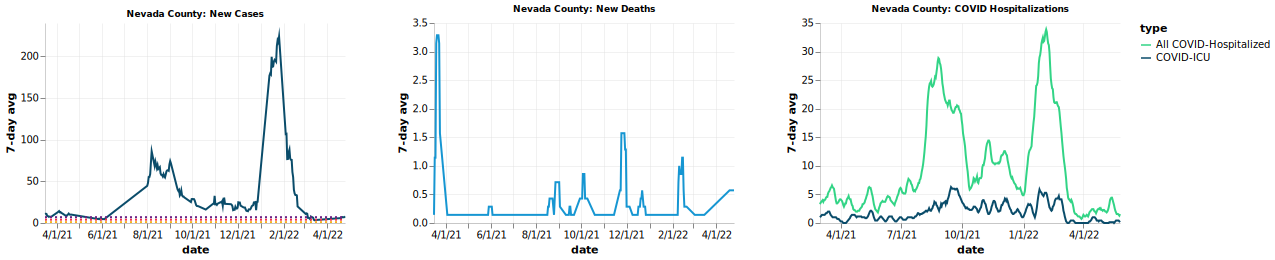

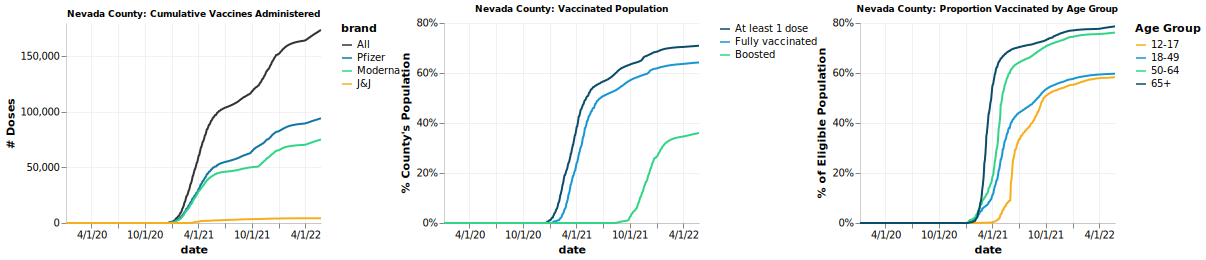

#### Orange, CA

As of 5/26/22, there were **609,875** total cases and **7,030** total deaths. <br>In the past week, new cases grew by **48.8%**; new deaths went from **0.6** to **1.0**. <br>New cases are **4.2x** higher than the Tier 4 cut-off. <i><span style='color:#797C7C'>(1 = Tier 4 widespread cut-off; 2 = new cases are 2x higher than the Tier 4 cut-off)</span></i>. <br>In the past week, the doubling time went from **846 days** to **834 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

In [ ]:
for c in ca_counties:
    id_anchor = c.replace(" - ", "-").replace(" ", "-")

    display(HTML(f"<a id={id_anchor}></a>"))
    plot_charts(jhu, hospitalizations, vaccinations, vaccinations_demog, c)
    display(HTML(
        "<br>"
        "<a href=#counties_by_region>Return to top</a><br>"
    ))

<a id=summary></a>

## Summary of CA Counties

In [ ]:
ca_boundary = gpd.read_file(f"{S3_FILE_PATH_SOURCE}ca_counties_boundary.geojson")

def grab_map_stats(df):
    # Let's grab the last available date for each county
    df = (df.sort_values(["county", "fips", "date2"], 
                         ascending = [True, True, False])
          .drop_duplicates(subset = ["county", "fips"], keep = "first")
          .reset_index(drop=True)
         )
    
    # Calculate its severity metric
    df = df.assign(
        severity = (df.cases_avg7 / df.tier3_case_cutoff).round(1)
    )
    
    # Make gdf
    gdf = pd.merge(ca_boundary, df, 
                   on = ["fips", "county"], how = "left", validate = "1:1")
    gdf = gdf.assign(
        cases_avg7 = gdf.cases_avg7.round(1),
        deaths_avg7 = gdf.deaths_avg7.round(1),
    )
    return gdf

gdf = grab_map_stats(jhu)

#### Severity by County
Severity measured as proportion relative to Tier 1 (minimal) threshold.
<br>*1 = at Tier 1 threshold*
<br>*2 = 2x higher than Tier 1 threshold*

In [ ]:
MAX_SEVERITY = gdf.severity.max()

light_gray = make_charts.light_gray

#https://stackoverflow.com/questions/47846744/create-an-asymmetric-colormap
"""
Against Tier 4 cut-off
If severity = 1 when case_rate = 7 per 100k
If severity = x when case_rate = 4 per 100k
If severity = y when case_rate = 1 per 100k
x = 4/7; y = 1/7

Against Tier 1 cut-off
If severity = 1 when case_rate = 1 per 100k
If severity = x when case_rate = 4 per 100k
If severity = y when case_rate = 7 per 100k
x = 4; y = 7
""" 
tier_4_colormap_cutoff = [
    (1/7), (4/7), 1, 2.5, 5
]

tier_1_colormap_cutoff = [
    1, 4, 7, 10, 15
]
# Note: CA reopening guidelines have diff thresholds based on how many vaccines are administered...
# We don't have vaccine info, so ignore, use original cut-offs
colormap_cutoff = tier_4_colormap_cutoff

colorscale = branca.colormap.StepColormap(
                colors=["#D0E700", "#F7AE1D", "#F77889", 
                        "#D59CE8", "#B249D4", "#6B1F84", # purples
                       ], 
                index=colormap_cutoff,
                vmin=0, vmax=MAX_SEVERITY,
)

popup_dict = {
    "county": "County",
    "severity": "Severity", 
}

tooltip_dict = {
    "county": "County: ",
    "severity": "Severity: ",
    "new_cases": "New Cases Yesterday: ", 
    "cases_avg7": "New Cases (7-day rolling avg): ",
    "new_deaths": "New Deaths Yesterday: ", 
    "deaths_avg7": "New Deaths (7-day rolling avg): ",
    "cases": "Cumulative Cases", 
    "deaths": "Cumulative Deaths", 
}


fig = make_maps.make_choropleth_map(gdf.drop(columns = ["date", "date2"]), 
                                    plot_col = "severity", 
                                    popup_dict = popup_dict, 
                                    tooltip_dict = tooltip_dict, 
                                    colorscale = colorscale, 
                                    fig_width = 570, fig_height = 700, 
                                    zoom=6, centroid = [36.2, -119.1])

In [ ]:
display(Markdown("Severity Scale"))
display(colorscale)
fig

In [ ]:
table = (gdf[gdf.severity.notna()]
         [["county", "severity"]]
         .sort_values("severity", ascending = False)
         .reset_index(drop=True)
        )

df1_styler = (table.iloc[:14].style.format({'severity': "{:.1f}"})
              .set_table_attributes("style='display:inline'")
              #.set_caption('Caption table 1')
              .hide_index()
             )
df2_styler = (table.iloc[15:29].style.format({'severity': "{:.1f}"})
              .set_table_attributes("style='display:inline'")
              #.set_caption('Caption table 2')
              .hide_index()
             )
df3_styler = (table.iloc[30:].style.format({'severity': "{:.1f}"})
              .set_table_attributes("style='display:inline'")
              #.set_caption('Caption table 2')
              .hide_index()
             )

display(Markdown("#### Counties (in order of decreasing severity)"))
display_html(df1_styler._repr_html_() + 
             df2_styler._repr_html_() + 
             df3_styler._repr_html_(), raw=True)
             

[Return to top](#counties_by_region)

In [ ]:
# Vaccination data by zip code
def select_latest_date(df):
    df = (df[df.date == df.date.max()]
          .sort_values(["county", "zipcode"])
          .reset_index(drop=True)
         )
    
    return df

vax_by_zipcode = neighborhood_utils.clean_zipcode_vax_data()
vax_by_zipcode = select_latest_date(vax_by_zipcode)

In [ ]:
popup_dict = {
    "county": "County",
    "zipcode": "Zip Code", 
    "fully_vaccinated_percent": "% Fully Vax"
}

tooltip_dict = {
    "county": "County: ",
    "zipcode": "Zip Code",
    "at_least_one_dose_percent": "% 1+ dose", 
    "fully_vaccinated_percent": "% fully vax"
}


colormap_cutoff = [
    0, 0.2, 0.4, 0.6, 0.8, 1
]

colorscale = branca.colormap.StepColormap(
                colors=["#CDEAF8", "#97BFD6", "#5F84A9", 
                        "#315174", "#17375E",
                       ], 
                index=colormap_cutoff,
                vmin=0, vmax=1,
)

fig = make_maps.make_choropleth_map(vax_by_zipcode.drop(columns = "date"), 
                                    plot_col = "fully_vaccinated_percent", 
                                    popup_dict = popup_dict, 
                                    tooltip_dict = tooltip_dict, 
                                    colorscale = colorscale, 
                                    fig_width = 570, fig_height = 700, 
                                    zoom=6, centroid = [36.2, -119.1])


<a id=vax_map></a>
#### Full Vaccination Rates by Zip Code

In [ ]:
display(Markdown("% Fully Vaccinated by Zip Code"))
display(colorscale)
fig

In [ ]:
zipcode_dropdown = ipywidgets.Dropdown(description="Zip Code", 
                                      options=sorted(vax_by_zipcode.zipcode.unique()),
                                       value=90012)
    
def make_map_show_table(x):
    plot_col = "fully_vaccinated_percent"

    popup_dict = {
        "county": "County",
        "zipcode": "Zip Code", 
        "fully_vaccinated_percent": "% Fully Vax"
    }

    tooltip_dict = {
        "county": "County: ",
        "zipcode": "Zip Code",
        "at_least_one_dose_percent": "% 1+ dose", 
        "fully_vaccinated_percent": "% fully vax"
    }

    colormap_cutoff = [
        0, 0.2, 0.4, 0.6, 0.8, 1
    ]

    colorscale = branca.colormap.StepColormap(
                    colors=["#CDEAF8", "#97BFD6", "#5F84A9", 
                            "#315174", "#17375E",
                           ], 
                    index=colormap_cutoff,
                    vmin=0, vmax=1,
    )

    fig_width = 300
    fig_height = 300
    zoom = 12
    df = vax_by_zipcode.copy()
    
    subset_df = (df[df.zipcode==x]
                 .assign(
                     # When calculating centroids, use EPSG:2229, but when mapping, put it back into EPSG:4326
                     # https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
                     lon = df.geometry.centroid.x,
                     lat = df.geometry.centroid.y,
                     county_partial_vax_avg = neighborhood_utils.calculate_county_avg(df, 
                                                                                     group_by="county",
                                                                                     output_col = "at_least_one_dose_percent"), 
                     county_full_vax_avg = neighborhood_utils.calculate_county_avg(df, 
                                                                                  group_by = "county",
                                                                                  output_col = "fully_vaccinated_percent"),
                     at_least_one_dose_percent = round(df.apply(lambda x: x.at_least_one_dose_percent * 100, axis=1), 0),
                     fully_vaccinated_percent = round(df.apply(lambda x: x.fully_vaccinated_percent * 100, axis=1), 0),
                 ).drop(columns = "date")
                )
    
    display_cols = ["county", "zipcode", "population", 
                   "% 1+ dose", "% fully vax", 
                   "county_partial_vax_avg", "county_full_vax_avg",
                   ]
    
    table = (subset_df.rename(columns = {
                     "at_least_one_dose_percent": "% 1+ dose", 
                     "fully_vaccinated_percent": "% fully vax",})
             [display_cols].style.format({
                '% 1+ dose': "{:.0f}%", 
                '% fully vax': "{:.0f}%", 
                'date': '{:%-m-%d-%y}', 
                'population': '{:,.0f}',
                'county_partial_vax_avg': '{:.0f}%',
                'county_full_vax_avg': '{:.0f}%',
            }).set_table_attributes("style='display:inline'")
        .hide_index()
    )
    
    display_html(table)
    
    center = [subset_df.lat, subset_df.lon]
    
    fig = make_maps.make_choropleth_map(subset_df, 
            plot_col, popup_dict, tooltip_dict, 
            colorscale, fig_width, fig_height, zoom, center)
    
    display(fig)

ipywidgets.interact(make_map_show_table, x=zipcode_dropdown)


[Return to top](#counties_by_region)